# Group Project Report

## Predicting User Knowledge Based on Degree of Exam Performance and Study Time
Katherine Kim, Nari Kim, Ali Manochehri

### Introduction

A user knowledge modeling system is a powerful tool with strong applications for exploring the knowledge of the target audience and creating efficient, personalized systems. It allows for individual content personalization, especially in online-learning environments (Kahraman et al., 2013). Our goal for this project is to predict the user’s knowledge level to optimize web-based adaptive learning environments by addressing the following question: 

**Can we predict the knowledge level of the user based on their degree of study time and exam performance for goal object materials?**

The two variables (degree of study time (STG) and exam performance (PEG)) to be used for our training model were carefully chosen to accurately reflect the level of knowledge of the user. It is known that increased study time leads to higher academic performance (Liu, 2022), while exam performance mirrors the level of knowledge retention, improving the accuracy of our classification training model to identify a user’s knowledge level.

To answer the question, we will be using the ‘User Knowledge Modeling’ dataset. In this dataset, a user’s knowledge status about the subject of electrical DC machines is classified as very low, low, middle, and high. It also includes variables that determine the degree of study time, repetition number, exam performance for related and goal object materials. We will use the degree of study time and exam performance as predictors for the user’s knowledge level.


### Summary of Method Used:

We loaded the necessary libraries and imported the User Modeling dataset from the internet to begin exploring our data.
For data wrangling, we created a summary table where we selected the columns STG and PEG as predictors and calculated the mean. Next, we summarized the user knowledge categories using the group_by function with summarize and count = n()  to see if there were any imbalances.

With the processed data in hand, we employed the k-nearest neighbors classification method to predict knowledge levels based on exam performance and study time to answer our main question. We split the data into training and testing sets using a 75/25 split. The model’s recipe took STG and PEG as predictors, and we performed cross-validation with 10 folds. We incorporated the vfold and tune functions in our workflow, and plotted a line graph of accuracy vs. k to determine the optimal k-value.

Then, we inputted the optimal k value into the final model, fit to our training data, and finally, predicted on the test data. To visually represent the model's accuracy on the unseen data, we created a bar graph of knowledge levels with two fill options: correct and incorrect predictions.

### Preliminary Exploratory Data Analysis

#### Importing libraries and reading the data

In [1]:
library(tidymodels)
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/nkim0/group_project/main/knowledge_data.csv",
                 show_col_types = FALSE)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.8
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.3     ✔ tibble       3.2.1
✔ ggplot2      3.5.0     ✔ tidyr        1.3.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.2.0

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.2     ✔ stringr   1.5.0

#### Wrangling the data and Splitting the data into training/testing

In [2]:
set.seed(22)

tidy_data_all <- data|>
    select(STG, SCG, STR, LPR, PEG, UNS) |>
    na.omit()

tidy_data_all$UNS <- factor(tidy_data_all$UNS, levels=c("very_low", "Low", "Middle", "High"))

tidy_data <- tidy_data_all |>
    select(STG, PEG, UNS) |>
    filter(UNS!="very_low")

knowledge_split <- initial_split(tidy_data, prop = 0.75, strata = UNS)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)

We removed the "very_low" category from our analysis due to imbalances.

#### Summarizing the data

In [3]:
knowledge_prediction_summary <- knowledge_train |>
    group_by(UNS) |>
    summarize(count = n())

mean_table <- knowledge_train |>
    select(STG, PEG) |>
    map_df(mean)

knowledge_prediction_summary 

UNS    count
1 Low    62   
2 Middle 66   
3 High   47

*Table 1: Summary table for levels of knowledge.*

In [4]:
mean_table

STG       PEG      
1 0.3706286 0.4933714

*Table 2: Average value of degree of study time (STG) and exam performance (PEG) on training data*

For data summarization, we summarized the user knowledge categories using the group_by function with summarize and count = n()  to see if there were any imbalances. Next, we created a summary table where we selected the columns STG and PEG as predictors and calculated the mean.

We removed the very_low category from our data analysis as it had a low amount of data compared to the low, middle, high categories, to ensure the categories are at relatively similar amounts for balanced classification. Omitting this category did not affect our analysis and interpretation of the data in this case because it was not an important class to identify. We already have a low category, which allows us to see the relationship between our predictors (STG and PEG) and three different levels of knowledge (low, middle, high). Additionally, no data columns had missing values. 

#### Visualizing relationships

As part of our preliminary data exploration, we created the visualization of the dataset by creating a scatter plot between exam performance (PEG) vs. degree of study time (STG). Each data point's color represents its corresponding knowledge level by identifying the trend between low (orange), middle (green), and high (blue) levels. This allowed us to see the relationship between the user’s  knowledge level, exam performance, and study time.

In [5]:
options(repr.plot.height = 5, repr.plot.width = 8)
relation_plot <- knowledge_train |>
    ggplot(aes(x=STG, y=PEG, color=UNS)) +
    geom_point() +
    labs(x="The degree of study time (0-1)", 
         y="The exam performance of user (0-1)", 
         color="The knowledge level of user") +
    theme(text=element_text(size=13))

prime_plot <- knowledge_train |> 
    ggplot(aes(fill=UNS)) + labs(fill="The knowledge level of user") + theme(text=element_text(size=15))

STG_distribution <- prime_plot +
    geom_histogram(aes(x=STG), bins=12) +
    ggtitle("Distribution of degree of study time for goal object material") +
    labs(x="Degree of study time (0-1)", y="frequency")

PEG_distribution <- prime_plot +
    geom_histogram(aes(x=STG), bins=12) +
    ggtitle("Distribution of exam performance of user for goal objects") +
    labs(x="Exam performance (0-1)", y="frequency")

relation_plot

*Figure 1: Exam performance for goal objects vs. degree of study time for goal object material*

We can see that there is no relationship between the degree of study time and the exam performance of the user. No relationship is found between the degree of study time and the knowledge level of the user as well. However, there seems to be a strong relationship between the knowledge level and exam performance for goal objects of the user. 

### Finding the Best K-value
We will find the best k-value by creating a tuning knn model and running the model on training set of 10-fold cross-validation. After fitting the model to the training data, we will collect the metrics of the accuracies and plot the accuracies versus k-value to find the optimum number of neighbors.

In [6]:
set.seed(22)

#creating the recipe
knowledge_recipe <- recipe(UNS ~ STG + PEG, data=knowledge_train)

#performing 10-fold cross-validation
knowledge_vfold <- vfold_cv(knowledge_train, v = 10, strata = UNS)

#creating the model specification
knn_tune_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_values <- tibble(neighbors = seq(from=1, to=20, by=2))

#creating the workflow and collecting metrics
knowledge_tune_result <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knn_tune_model) |>
    tune_grid(resamples = knowledge_vfold, grid = k_values) |>
    collect_metrics()

#filtering for accuracy
accuracies <- knowledge_tune_result |>
    filter(.metric == 'accuracy')

#plotting accuracy vs. k-value 
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() + geom_point() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 20))

#finding the best k-value
best_k <- accuracies |>
    slice_max(mean, n = 1) |>
    pull(neighbors)
    
best_k
cross_val_plot

→ A | warning: No observations were detected in `truth` for level(s): 'very_low'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x3

There were issues with some computations   A: x8

There were issues with some computations   A: x10





[1] 9

*Figure 2: Plot of estimated accuracy versus the number of neighbors.*

From the graph of accuracy versus neighbors, we find that the best k-value is 9. Using this k-value, we will create the final knn model and fit the data into the model. Using this final fit, we will predict testing data and collect the accuracy.

#### Building our final model, Evaluating on the test set

In [7]:
#retraining our K-NN classifier using the best k
knowledge_final_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knowledge_final_fit <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knowledge_final_model) |>
    fit(data = knowledge_train)

#making predictions on test data
knowledge_prediction <- predict(knowledge_final_fit, knowledge_test) |>
    bind_cols(knowledge_test)

#removing the unused factors
knowledge_prediction$UNS <- droplevels(knowledge_prediction$UNS)
knowledge_prediction$.pred_class <- droplevels(knowledge_prediction$.pred_class)

# measuring the accuracy of the model
knowledge_final_result <- knowledge_prediction |>
    metrics(truth = UNS, estimate = .pred_class) |>
    filter(.metric=="accuracy")

# creating the confusion matrix
knowledge_confusion_matrix <- knowledge_prediction |>
    conf_mat(truth = UNS, estimate = .pred_class)

best_k
knowledge_final_result

[1] 9

.metric  .estimator .estimate
1 accuracy multiclass 0.9322034

*Table 3: accuracy of the final kkn model*

In [8]:
knowledge_confusion_matrix

          Truth
Prediction Low Middle High
    Low     21      2    0
    Middle   0     20    2
    High     0      0   14

*Table 4: confusion table for prediction of knowledge levels*

From table 3, we find the accuracy of our model to be 93%. Our model predicted 52 out of 59 observations correctly, which is not terrible considering that the misclassifications are in close proximity (identifying low knowledge level as a middle knowledge level, not predicting low knowledge level as a high knowledge level).

#### Visualization of results

For visualization of our results, we created a scatter plot, with the prediction class of each point as the color and the background colour of the graph showing the separation between each class of UNS.

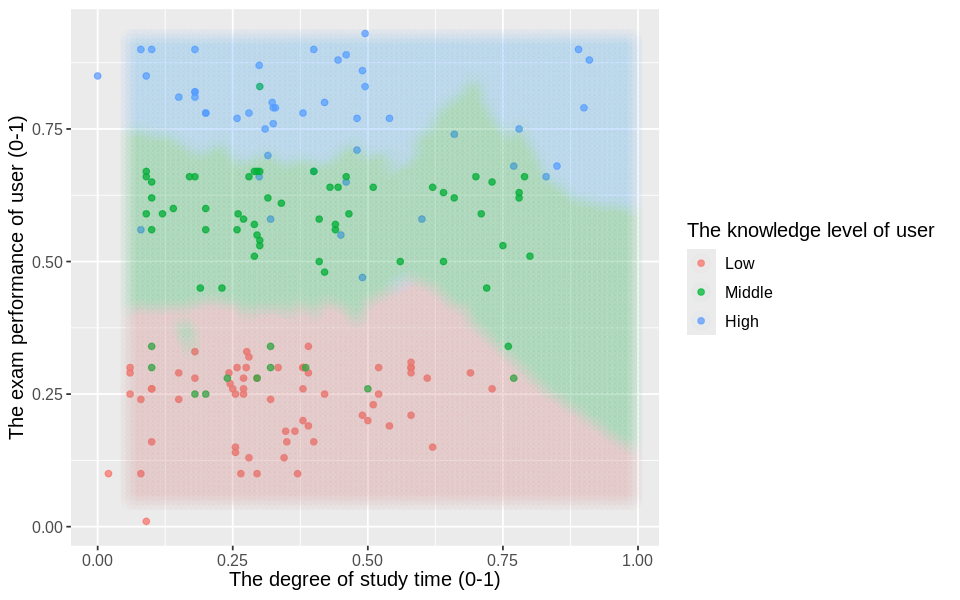

In [9]:
STG_grid <- seq(min(knowledge_test$STG),
                max(knowledge_test$STG),
                length.out = 100)
PEG_grid <- seq(min(knowledge_test$PEG),
                max(knowledge_test$PEG),
                length.out = 100)
spgrid <- as_tibble(expand.grid(STG = STG_grid,
                                PEG = PEG_grid))

knnPredGrid <- predict(knowledge_final_fit, spgrid)

prediction_table <- bind_cols(knnPredGrid, spgrid) |>
                    rename(UNS = .pred_class)

# UNS_plot <- ggplot() +
#  geom_point(data = knowledge_test,
#             mapping = aes(x = STG,
#                           y = PEG,
#                           color = UNS),
#             alpha = 0.75) +
#  geom_point(data = knowledge_prediction,
#             mapping = aes(x = STG,
#                           y = PEG,
#                           color = .pred_class),
#             alpha = 0.02,
#             size = 5) +
#  labs(x="The degree of study time (0-1)", 
#       y="The exam performance of user (0-1)", 
#       color="The knowledge level of user") +
#  theme(text = element_text(size = 12))

UNS_plot <- ggplot() +
  geom_point(data = knowledge_train,
             mapping = aes(x = STG,
                           y = PEG,
                           color = UNS),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = STG,
                           y = PEG,
                           color = UNS),
             alpha = 0.02, 
             size = 5) +
  labs(x="The degree of study time (0-1)", 
       y="The exam performance of user (0-1)", 
       color="The knowledge level of user") +
  theme(text = element_text(size = 12))

UNS_plot

*Figure 3: Scatter plot of exam performance of user versus degree of study time where background color indicates the decision of the classifier.*

Looking at the graph 3, we can see that the classifier is fairly good at predicting the data, and we can trust that our classifier will be able to predict the user knowledge level of new data.

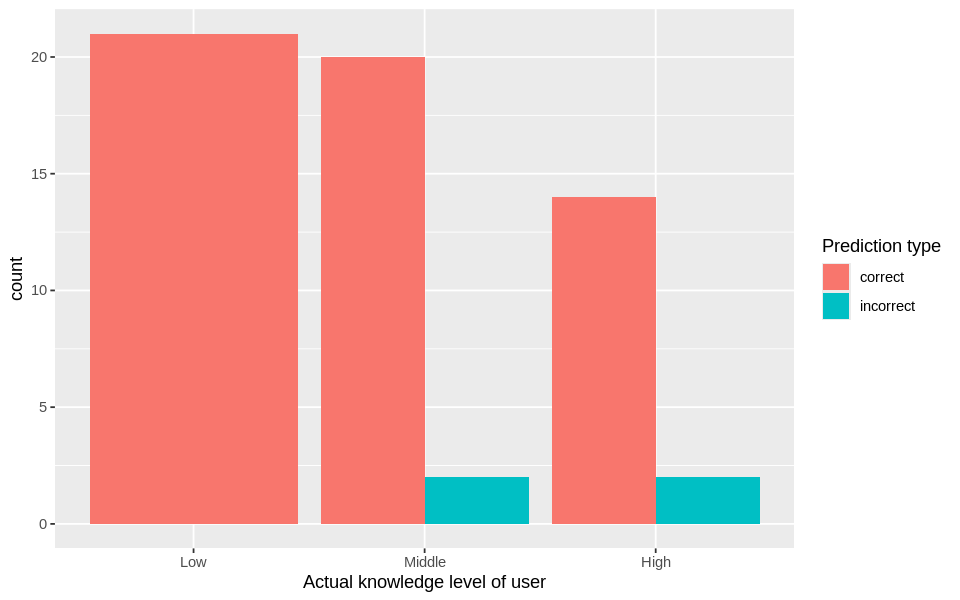

In [25]:
# classifying the type predictions to correct or incorrect
correct_prediction <- knowledge_prediction |>
    filter(.pred_class==UNS) |>
    mutate(prediction_type="correct")
incorrect_prediction <- knowledge_prediction |>
    filter(.pred_class!=UNS) |>
    mutate(prediction_type="incorrect")

# merging the different types of prediction
correctness_predictions <- bind_rows(correct_prediction, incorrect_prediction)

# creating the correctness of prediction's plot
correctness_plot <- ggplot(correctness_predictions, aes(x=UNS, fill=prediction_type)) +
    geom_bar(position="dodge", stat="count") +
    labs(x = "Actual knowledge level of user", y = "count", fill = "Prediction type")

correctness_plot

Figure 4: bar graph for correctness of predicted knowledge level of user versus actual knowledge level of user

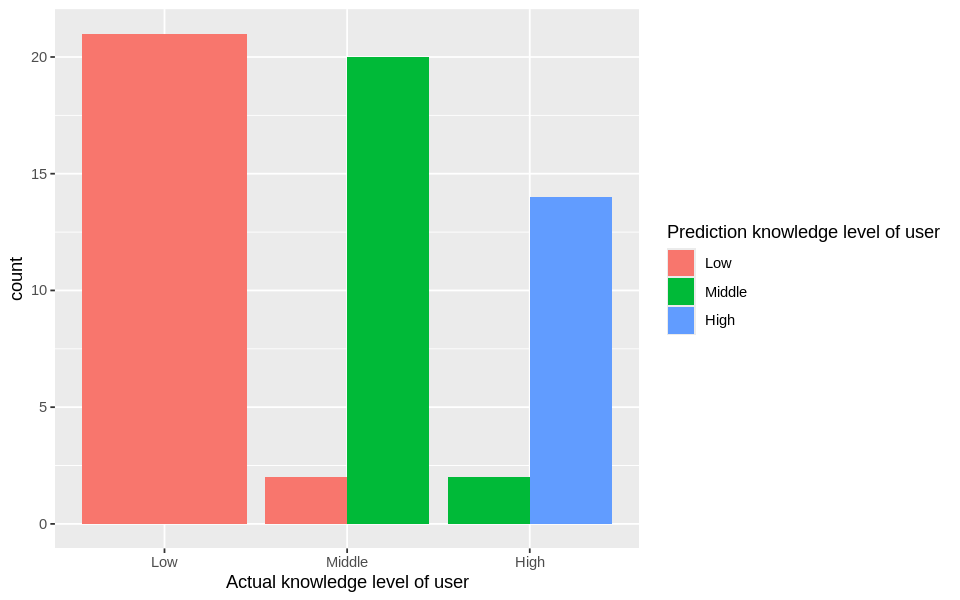

In [10]:
prediction_result_plot <- knowledge_prediction |>
    ggplot(aes(x=UNS, fill=.pred_class)) +
    geom_bar(position="dodge", stat="count") +
    labs(x = "Actual knowledge level of user", y = "count", fill = "Prediction knowledge level of user")
prediction_result_plot

Figure 5: Bar graph of prediction versus the actual knowledge level of users

### Discussion

General findings:
According to our codings, we concluded the data of our model ended up having 93% accuracy. By wrangling, cleaning, and summarizing the data for the desired target value UNS “The knowledge level of the user”, we used the 2 data sets of PEG (Exam performance of students on goal objects) and STG (Time spent studying for goal objects). The final visualization of our classified data revealed that there is no correlation between the degree of study time and the exam performance of the students. As shown in the scatter plot, the blue points indicate the high level of knowledge of students, and they tend to show successful exam performance close to 1. However, the STG, the time spent studying didn’t show any correlation with either the knowledge level of students or the exam performance. If we take a look at the graph, the points were almost clustered on the left instead of the right. If they have a relationship between other values, the points should have been dispersed on the right by showing that increased study time results in higher exam scores. Therefore, we can conclude there is a relationship between the knowledge level and the exam performance as students with high levels of knowledge tend to perform well on the exam. However, the students who spent more time studying the specific goal object did not tend to have higher results on exam performance. To conclude, it mainly depends on the knowledge level of the students that determines how well the student performs on an exam.

The data and visualization were similar to the expected outcomes and predictions we have made from the group proposal which was to find a student’s knowledge level with study time and exam performance both for goal object materials (Kahraman et al., 2013). The preliminary analysis allowed us to find the relationship between each STG, PEG, and UNS. By these outcomes, we were able to conclude there was no relationship between knowledge level and the time spent studying. There was also no linkage between the x-axis and the y-axis, meaning that exam performance does not depend on the study time but it’s based on the knowledge level of students for this goal object’s exam. However, we chose to wrangle and clean data for STG and PEG among other input values, and there were some limitations in determining why there was no correlation with study time. Even though there were some limitations in confirming if it’s an accurate expected result as STG did not have any relations with either PEG or UNS. By foreclosing STG data, we were able to conclude that exam performance was based on the knowledge level of students for the goal objects and vice versa.

Summary of impact based on findings and generating future questions:

Such findings will impact the level of completion for electrical DC machines web-based learning platforms when students are put into the actual practical engineering. Identifying students who need extra studies by determining the minimum score before moving to the next step or determining the regulation prior to moving on to the next exams. Even though they had no correlation between study time spent, this can provide useful information as they will evaluate the exam performance and their knowledge level. So, in-depth we can regenerate the impact by setting up the prerequisites for the exam or the course to students to complete studying goal objects successfully. Moreover, the teaching team can produce statistics of what should be taught to increase the exam performance based on the knowledge level of the student and the exam performance. It is easily determined if the exam was performed based only on the knowledge as the common part will be poorly performed by students which allows professors to know which parts they are struggling with.

These outcomes will also generate questions about the minimum passing score for students to successfully gain knowledge, using data of performance in the next exams and outcomes we obtained. Doing poorly on the next step’s exam means studies of previous goal objects were not fully knowledgeable. Therefore, setting the standard passing score can be used for future related exams to prove the promotion of the next studies based on their knowledge level.

### References

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009

Liu, M. (2022). The relationship between students’ study time and academic performance and its practical significance. BCP Education & Psychology, 7, 412–415. https://doi.org/10.54691/bcpep.v7i.2696